In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/work

Mounted at /content/drive
/content/drive/MyDrive/work


今回は既に「リポジトリのクローン」、「事前学習済みモデルのダウンロード」を別途行っていたので、この処理を飛ばす。

In [3]:
%cd ./D-FINE

/content/drive/MyDrive/work/D-FINE


# D-FINEのリポジトリをクローン

In [ ]:
!git clone https://github.com/Peterande/D-FINE.git
%cd D-FINE

# 事前学習済みモデルのダウンロード

In [ ]:
!wget !wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_n_coco.pth

ここから実行

# パッケージのインストール

In [11]:
!pip install -U pip
!pip install -r requirements.txt
!pip install onnx onnxruntime onnxsim opencv-python
!pip install numpy==1.23.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 169.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 151.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.23.1 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but 

In [1]:
%cd /content/drive/MyDrive/work/D-FINE/

/content/drive/MyDrive/work/D-FINE


# 学習設定ファイルの準備

In [9]:
%%writefile dfine_hgnetv2_n_person_416x416.yml

__include__: [
  'person_detection.yml',
  'configs/runtime.yml',
  'dataloader.yml',
  'configs/dfine/include/optimizer.yml',
  'dfine_hgnetv2.yml',
]

output_dir: ./output/dfine_hgnetv2_n_person_416x416


DFINE:
  backbone: HGNetv2

HGNetv2:
  name: 'B0'
  return_idx: [2, 3]
  freeze_at: -1
  freeze_norm: False
  use_lab: True


HybridEncoder:
  in_channels: [512, 1024]
  feat_strides: [16, 32]

  # intra
  hidden_dim: 128
  use_encoder_idx: [1]
  dim_feedforward: 512

  # cross
  expansion: 0.34
  depth_mult: 0.5


DFINETransformer:
  feat_channels: [128, 128]
  feat_strides: [16, 32]
  hidden_dim: 128
  dim_feedforward: 512
  num_levels: 2

  num_layers: 3
  eval_idx: -1

  num_points: [6, 6]

optimizer:
  type: AdamW
  params:
    -
      params: '^(?=.*backbone)(?!.*norm|bn).*$'
      lr: 0.0004
    -
      params: '^(?=.*backbone)(?=.*norm|bn).*$'
      lr: 0.0004
      weight_decay: 0.
    -
      params: '^(?=.*(?:encoder|decoder))(?=.*(?:norm|bn|bias)).*$'
      weight_decay: 0.

  lr: 0.0008
  betas: [0.9, 0.999]
  weight_decay: 0.0001


# Increase to search for the optimal ema
epoches: 132 # 120 + 4n
train_dataloader:
  #total_batch_size: 128
  dataset:
    transforms:
      policy:
        epoch: 120
  collate_fn:
    stop_epoch: 120
    ema_restart_decay: 0.9999
    base_size_repeat: ~

#val_dataloader:
  #total_batch_size: 256

Writing dfine_hgnetv2_n_person_416x416.yml


In [5]:
%%writefile person_detection.yml

task: detection

evaluator:
  type: CocoEvaluator
  iou_types: ['bbox', ]

num_classes: 2 # データセットのクラス数+1
remap_mscoco_category: False

train_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: /content/drive/MyDrive/work/datasets/person/images/Train
    ann_file: /content/drive/MyDrive/work/datasets/person/annotations/instances_Train.json
    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: True
  num_workers: 4
  drop_last: True
  collate_fn:
    type: BatchImageCollateFunction

val_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: /content/drive/MyDrive/work/datasets/person/images/Validation
    ann_file: /content/drive/MyDrive/work/datasets/person/annotations/instances_Validation.json
    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: False
  num_workers: 4
  drop_last: False
  collate_fn:
    type: BatchImageCollateFunction

Overwriting person_detection.yml


In [6]:
%%writefile dataloader.yml

train_dataloader:
  dataset:
    transforms:
      ops:
        - {type: RandomPhotometricDistort, p: 0.5}
        - {type: RandomZoomOut, fill: 0}
        - {type: RandomIoUCrop, p: 0.8}
        - {type: SanitizeBoundingBoxes, min_size: 1}
        - {type: RandomHorizontalFlip}
        - {type: Resize, size: [416, 416], }
        - {type: SanitizeBoundingBoxes, min_size: 1}
        - {type: ConvertPILImage, dtype: 'float32', scale: True}
        - {type: ConvertBoxes, fmt: 'cxcywh', normalize: True}
      policy:
        name: stop_epoch
        epoch: 72 # epoch in [71, ~) stop `ops`
        ops: ['RandomPhotometricDistort', 'RandomZoomOut', 'RandomIoUCrop']

  collate_fn:
    type: BatchImageCollateFunction
    base_size: 416
    base_size_repeat: 3
    stop_epoch: 72 # epoch in [72, ~) stop `multiscales`

  shuffle: True
  total_batch_size: 32 # total batch size equals to 32 s(4 * 8)
  num_workers: 4


val_dataloader:
  dataset:
    transforms:
      ops:
        - {type: Resize, size: [416, 416], }
        - {type: ConvertPILImage, dtype: 'float32', scale: True}
  shuffle: False
  total_batch_size: 64
  num_workers: 4

Writing dataloader.yml


In [8]:
%%writefile dfine_hgnetv2.yml

task: detection

model: DFINE
criterion: DFINECriterion
postprocessor: DFINEPostProcessor

use_focal_loss: True
eval_spatial_size: [416, 416] # h w

DFINE:
  backbone: HGNetv2
  encoder: HybridEncoder
  decoder: DFINETransformer

HGNetv2:
  pretrained: True
  local_model_dir: weight/hgnetv2/

HybridEncoder:
  in_channels: [512, 1024, 2048]
  feat_strides: [8, 16, 32]

  # intra
  hidden_dim: 256
  use_encoder_idx: [2]
  num_encoder_layers: 1
  nhead: 8
  dim_feedforward: 1024
  dropout: 0.
  enc_act: 'gelu'

  # cross
  expansion: 1.0
  depth_mult: 1
  act: 'silu'


DFINETransformer:
  feat_channels: [256, 256, 256]
  feat_strides: [8, 16, 32]
  hidden_dim: 256
  num_levels: 3

  num_layers: 6
  eval_idx: -1
  num_queries: 300

  num_denoising: 100
  label_noise_ratio: 0.5
  box_noise_scale: 1.0

  # NEW
  reg_max: 32
  reg_scale: 4

  # Auxiliary decoder layers dimension scaling
  # "eg. If num_layers: 6 eval_idx: -4,
  # then layer 3, 4, 5 are auxiliary decoder layers."
  layer_scale: 1  # 2


  num_points: [3, 6, 3] # [4, 4, 4] [3, 6, 3]
  cross_attn_method: default # default, discrete
  query_select_method: default # default, agnostic


DFINEPostProcessor:
  num_top_queries: 300


DFINECriterion:
  weight_dict: {loss_vfl: 1, loss_bbox: 5, loss_giou: 2, loss_fgl: 0.15, loss_ddf: 1.5}
  losses: ['vfl', 'boxes', 'local']
  alpha: 0.75
  gamma: 2.0
  reg_max: 32

  matcher:
    type: HungarianMatcher
    weight_dict: {cost_class: 2, cost_bbox: 5, cost_giou: 2}
    alpha: 0.25
    gamma: 2.0

Writing dfine_hgnetv2.yml


# 学習実行

In [2]:
!CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 train.py \
-c dfine_hgnetv2_n_person_416x416.yml -t dfine_n_coco.pth --use-amp --seed=0

2024-11-10 01:09:05.807559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 01:09:05.829841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 01:09:05.835770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 01:09:05.850046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 01:09:06.934885: W tensorflow/comp

# 評価

In [3]:
!CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 train.py \
-c dfine_hgnetv2_n_person_416x416.yml \
-r output/dfine_hgnetv2_n_person_416x416/best_stg2.pth --test-only

2024-11-10 01:27:44.194984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 01:27:44.214508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 01:27:44.220331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 01:27:44.234504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 01:27:45.389178: W tensorflow/comp

# Torch推論

In [8]:
%%writefile torch_inf_416x416.py

"""
Copyright (c) 2024 The D-FINE Authors. All Rights Reserved.
"""
import time

import torch
import torch.nn as nn
import torchvision.transforms as T

import numpy as np
from PIL import Image, ImageDraw

import sys
import os
import cv2  # Added for video processing

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../../')))
from src.core import YAMLConfig


def draw(images, labels, boxes, scores, thrh=0.4):
    for i, im in enumerate(images):
        draw = ImageDraw.Draw(im)

        scr = scores[i]
        lab = labels[i][scr > thrh]
        box = boxes[i][scr > thrh]
        scrs = scr[scr > thrh]

        for j, b in enumerate(box):
            draw.rectangle(list(b), outline='red')
            draw.text(
                (b[0], b[1]),
                text=f"{lab[j].item()} {round(scrs[j].item(), 2)}",
                fill='blue',
            )

        im.save('torch_results_416x416.jpg')


def process_image(model, device, file_path, input_size):
    im_pil = Image.open(file_path).convert('RGB')
    w, h = im_pil.size
    orig_size = torch.tensor([[w, h]]).to(device)

    transforms = T.Compose([
        T.Resize((input_size, input_size)),
        T.ToTensor(),
    ])
    im_data = transforms(im_pil).unsqueeze(0).to(device)
    output = model(im_data, orig_size)
    labels, boxes, scores = output

    draw([im_pil], labels, boxes, scores)


def process_video(model, device, file_path):
    cap = cv2.VideoCapture(file_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('torch_results.mp4', fourcc, fps, (orig_w, orig_h))

    transforms = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
    ])

    frame_count = 0
    print("Processing video frames...")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to PIL image
        frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        w, h = frame_pil.size
        orig_size = torch.tensor([[w, h]]).to(device)

        im_data = transforms(frame_pil).unsqueeze(0).to(device)

        output = model(im_data, orig_size)
        labels, boxes, scores = output

        # Draw detections on the frame
        draw([frame_pil], labels, boxes, scores)

        # Convert back to OpenCV image
        frame = cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)

        # Write the frame
        out.write(frame)
        frame_count += 1

        if frame_count % 10 == 0:
            print(f"Processed {frame_count} frames...")

    cap.release()
    out.release()
    print("Video processing complete. Result saved as 'results_video.mp4'.")


def main(args):
    """Main function"""
    cfg = YAMLConfig(args.config, resume=args.resume)

    if 'HGNetv2' in cfg.yaml_cfg:
        cfg.yaml_cfg['HGNetv2']['pretrained'] = False

    if args.resume:
        checkpoint = torch.load(args.resume, map_location='cpu')
        if 'ema' in checkpoint:
            state = checkpoint['ema']['module']
        else:
            state = checkpoint['model']
    else:
        raise AttributeError('Only support resume to load model.state_dict by now.')

    # Load train mode state and convert to deploy mode
    cfg.model.load_state_dict(state)

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = cfg.model.deploy()
            self.postprocessor = cfg.postprocessor.deploy()

        def forward(self, images, orig_target_sizes):
            outputs = self.model(images)
            outputs = self.postprocessor(outputs, orig_target_sizes)
            return outputs

    device = args.device
    model = Model().to(device)

    # Check if the input file is an image or a video
    file_path = args.input
    if os.path.splitext(file_path)[-1].lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
        # Process as image
        process_image(model, device, file_path, args.input_size)
        print("Image processing complete.")
    else:
        # Process as video
        process_video(model, device, file_path)


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-c', '--config', type=str, required=True)
    parser.add_argument('-r', '--resume', type=str, required=True)
    parser.add_argument('-i', '--input', type=str, required=True)
    parser.add_argument('-is', '--input_size', type=int, default=640)
    parser.add_argument('-d', '--device', type=str, default='cpu')
    args = parser.parse_args()
    main(args)


Overwriting torch_inf_416x416.py


In [9]:
!python3 torch_inf_416x416.py -c dfine_hgnetv2_n_person_416x416.yml -r output/dfine_hgnetv2_n_person_416x416/best_stg2.pth \
-i /content/drive/MyDrive/work/datasets/person/images/Validation/images/valid/1_190_jpg.rf.bb7317b6c07a6576a42c50af4e4576ed.jpg \
--device cuda --input_size 416

2024-11-10 01:32:16.565374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 01:32:16.629581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 01:32:16.635425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 01:32:16.649420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 01:32:18.031954: W tensorflow/comp

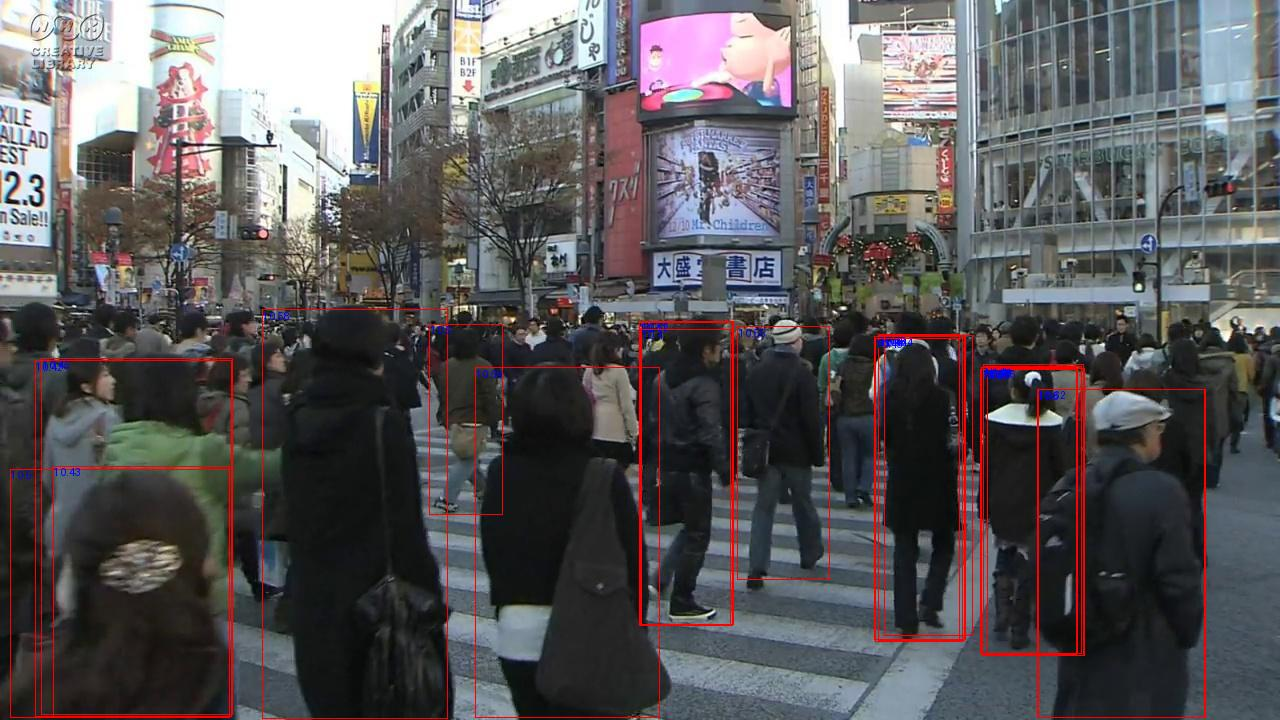

In [10]:
import cv2
from google.colab.patches import cv2_imshow

torch_result_img = cv2.imread('torch_results_416x416.jpg')
cv2_imshow(torch_result_img)

# ONNX変換・推論

In [14]:
%%writefile export_onnx_416x416.py

import os
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(__file__)), '../..'))

import torch
import torch.nn as nn

from src.core import YAMLConfig


def main(args, ):
    """main
    """
    cfg = YAMLConfig(args.config, resume=args.resume)

    if 'HGNetv2' in cfg.yaml_cfg:
        cfg.yaml_cfg['HGNetv2']['pretrained'] = False

    if args.resume:
        checkpoint = torch.load(args.resume, map_location='cpu')
        if 'ema' in checkpoint:
            state = checkpoint['ema']['module']
        else:
            state = checkpoint['model']

        # NOTE load train mode state -> convert to deploy mode
        cfg.model.load_state_dict(state)

    else:
        # raise AttributeError('Only support resume to load model.state_dict by now.')
        print('not load model.state_dict, use default init state dict...')

    class Model(nn.Module):
        def __init__(self, ) -> None:
            super().__init__()
            self.model = cfg.model.deploy()
            self.postprocessor = cfg.postprocessor.deploy()

        def forward(self, images, orig_target_sizes):
            outputs = self.model(images)
            outputs = self.postprocessor(outputs, orig_target_sizes)
            return outputs

    model = Model()
    input_size = args.input_size
    data = torch.rand(1, 3, input_size, input_size)
    size = torch.tensor([[input_size, input_size]])
    _ = model(data, size)

    dynamic_axes = {
        'images': {0: 'N', },
        'orig_target_sizes': {0: 'N'}
    }

    output_file = args.resume.replace('.pth', '.onnx') if args.resume else 'model.onnx'

    torch.onnx.export(
        model,
        (data, size),
        output_file,
        input_names=['images', 'orig_target_sizes'],
        output_names=['labels', 'boxes', 'scores'],
        dynamic_axes=dynamic_axes,
        opset_version=16,
        verbose=False,
        do_constant_folding=True,
    )

    if args.check:
        import onnx
        onnx_model = onnx.load(output_file)
        onnx.checker.check_model(onnx_model)
        print('Check export onnx model done...')

    if args.simplify:
        import onnx
        import onnxsim
        dynamic = True
        # input_shapes = {'images': [1, 3, 640, 640], 'orig_target_sizes': [1, 2]} if dynamic else None
        input_shapes = {'images': data.shape, 'orig_target_sizes': size.shape} if dynamic else None
        onnx_model_simplify, check = onnxsim.simplify(output_file, test_input_shapes=input_shapes)
        onnx.save(onnx_model_simplify, output_file)
        print(f'Simplify onnx model {check}...')


if __name__ == '__main__':

    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', '-c', default='configs/dfine/dfine_hgnetv2_l_coco.yml', type=str, )
    parser.add_argument('--resume', '-r', type=str, )
    parser.add_argument('--input_size', '-is', type=int, default=640)
    parser.add_argument('--check',  action='store_true', default=True,)
    parser.add_argument('--simplify',  action='store_true', default=True,)
    args = parser.parse_args()
    main(args)

Overwriting export_onnx_416x416.py


In [17]:
!python3 export_onnx_416x416.py \
-c dfine_hgnetv2_n_person_416x416.yml \
-r output/dfine_hgnetv2_n_person_416x416/best_stg2.pth \
--simplify --check --input_size 416

2024-11-10 01:37:09.683754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 01:37:09.712851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 01:37:09.718809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 01:37:09.733374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 01:37:10.859143: W tensorflow/comp

In [19]:
import copy

import cv2
import numpy as np
import onnxruntime

# モデル読み込み
model_path = "output/dfine_hgnetv2_n_person_416x416/best_stg2.onnx"
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
onnx_session = onnxruntime.InferenceSession(
    model_path,
    providers=providers
)
input_size = onnx_session.get_inputs()[0].shape
input_width, input_height = input_size[3], input_size[2]

print('input size:',input_size)

# 画像読み込み
imapt_path = "/content/drive/MyDrive/work/datasets/person/images/Validation/images/valid/1_190_jpg.rf.bb7317b6c07a6576a42c50af4e4576ed.jpg"
image = cv2.imread(imapt_path)
image_height, image_width, _ = image.shape
original_size = np.array([[image_width, image_height]], dtype=np.int64)

# 前処理：BGR->RGB、リサイズ、正規化、NCHW
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (input_width, input_height))
input_image = input_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

# 推論
output = onnx_session.run(
    None,
    input_feed={'images': input_image, "orig_target_sizes": original_size}
)
labels, bboxes, scores = output

# 描画
debug_image = copy.deepcopy(image)
score_threshold = 0.4

for label, bbox, score in zip(labels[0], bboxes[0], scores[0]):
    if score < score_threshold:
        continue

    cv2.rectangle(
        debug_image,
        (int(bbox[0]), int(bbox[1])),
        (int(bbox[2]), int(bbox[3])),
        (0, 255, 0),
        2,
    )
    cv2.putText(
        debug_image,
        str(label),
        (int(bbox[0]), int(bbox[1]-8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
    )

input size: ['N', 3, 416, 416]


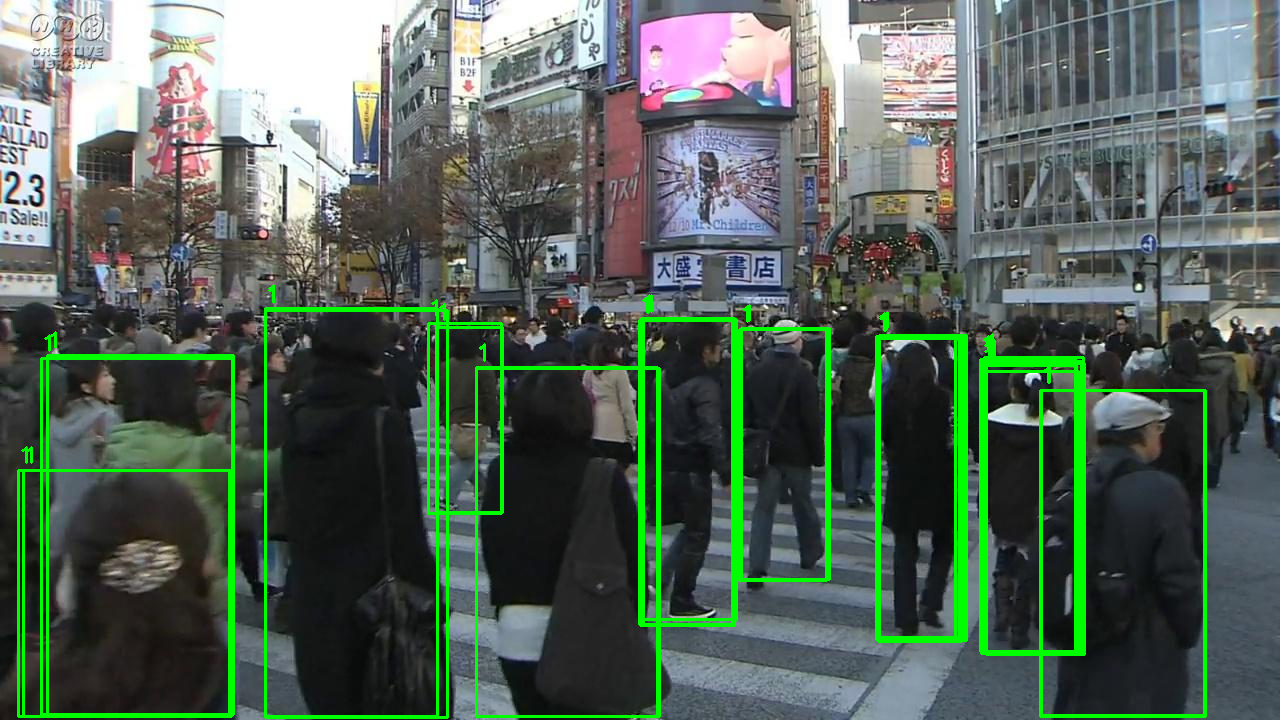

In [20]:
from google.colab.patches import cv2_imshow
cv2_imshow(debug_image)